# PA_4: Feedforward Neural Network

## Aim
Train and test a Feedforward Neural Network for MNIST digit classification.

## Procedure
* Download `mnist_file.rar` which contains mnist data as a *pickle* file and read `mnist.py` for loading partial mnist data.
* Run read `mnist.py` file which will give 1000 train and 500 test images per each class.
* x train,y train gives the image $784\times1$ and corresponding label for training data. Similarly, for test data.
* Write
    1. Neural network model using library functions.
    2. Your own neural network model and train with Back propagation
* Test both models with the test data.
* Find the confusion matrix and report the accuracy.

Train data label dim: (10000,)
Train data features dim: (10000, 784)
Test data label dim: (5000,)
Test data features dim:(5000, 784)


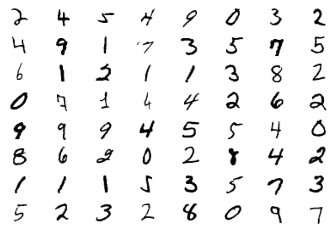

In [2]:
import numpy as np
from utils import visualise
from read_mnist import load_data
import random

y_train,x_train,y_test,x_test=load_data()

print("Train data label dim: {}".format(y_train.shape))
print("Train data features dim: {}".format(x_train.shape))
print("Test data label dim: {}".format(y_test.shape))
print("Test data features dim:{}".format(x_test.shape))

visualise(x_train)

In [2]:
import numpy as np
import random
import itertools
import time
from sklearn.metrics import f1_score, precision_score, recall_score
from read_mnist import load_data
import pickle

def sigmoid(x):
    return 1.0/(1+ np.exp(-x))

def sigmoid_grad(x):
    return x * (1 - x)

def tanh_grad(x):
    return 1-np.power(x,2)

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x /np.sum(e_x, axis=1, keepdims=True)

def relu(x):
    return x * (x > 0)

def relu_grad(x):
    return (x>0)*1

def cross_entropy(y_,y):
    n = y.shape[0]
    nll = -np.log(y_[range(n),y])
    return np.mean(nll)

def delta_cross_entropy(y_,y):
    n = y.shape[0]
    y_[range(n),y] -= 1
    return y_/n

class NN:
    def __init__(self, hidden_layers, hidden_neurons, hidden_activation, lr=0.01):
        self.hidden_layers = hidden_layers
        self.hidden_neurons = hidden_neurons
        self.hidden_activation = hidden_activation
        self.lr=lr
        np.random.seed(786)
        self.W1 = 0.1* np.random.randn(x_train.shape[1],self.hidden_neurons)
        self.b1 = np.zeros((1,self.hidden_neurons))
        self.W2 = 0.1* np.random.randn(self.hidden_neurons,10)
        self.b2 = np.zeros((1,10))

    def forward(self,x_train):
        s1=np.dot(x_train, self.W1) + self.b1
        if self.hidden_activation == 'sigmoid':
            a1 = sigmoid(s1)
        elif self.hidden_activation=='tanh':
            a1 = np.tanh(s1)
        elif self.hidden_activation=='relu':
            a1 = relu(s1)
        else:
            raise Exception('Error: Activation not implemented')
        s2 = np.dot(a1, self.W2) + self.b2
        a2 = softmax(s2)
        loss=cross_entropy(a2,y_train)
        return(loss,s1,a1,s2,a2)


    def backward(self, s1, a1, s2, a2):
        delta3=delta_cross_entropy(a2,y_train)
        dW2 = np.dot(a1.T, delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        if self.hidden_activation=='sigmoid':
            delta2 = delta3.dot(self.W2.T) * sigmoid_grad(a1)
        elif self.hidden_activation == 'tanh':
            delta2 = delta3.dot(self.W2.T) * tanh_grad(a1)
        elif self.hidden_activation == 'relu':
            delta2 = delta3.dot(self.W2.T) * relu_grad(a1)
        else:
            raise Exception('Error: Activation not implemented')
            
        dW1 = np.dot(x_train.T, delta2)
        db1 = np.sum(delta2, axis=0)

        self.W1 += -self.lr * dW1
        self.b1 += -self.lr * db1
        self.W2 += -self.lr * dW2
        self.b2 += -self.lr * db2
        
    def predict(self, x):
        s1=np.dot(x, self.W1)
        a1 = (sigmoid(s1))
        s2 = np.dot(a1, self.W2)
        a2 = softmax(s2)
        return np.argmax(a2, axis=1)
    
    def save_model(self, name):
        params = { 'W1': self.W1, 'b1': self.b1, 'W2': self.W2, 'b2': self.b2}
        with open(name, 'wb') as handle:
            pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)

epochs=1000
# hyperparameter variation
lr=0.1
neurons = [32,64,128,256]
activations = ['sigmoid', 'relu', 'tanh']

experiments = list(itertools.product(neurons, activations))

for (hidden_neurons,hidden_activation) in experiments:
    print('\n############ Activation function: {} No. of neurons: {} ############'.format(hidden_activation, hidden_neurons))
    model=NN(hidden_layers=5,hidden_neurons=hidden_neurons,hidden_activation=hidden_activation, lr=lr)
    print('\nTraining started!')
    start = time.time()
    
    for epoch in range(epochs):
        loss,s1,a1,s2,a2 = model.forward(x_train)
        if epoch%100==0:
            print("Loss: {} Training progress: {}/{}".format(loss,epoch,epochs))
        model.backward(s1, a1, s2, a2)
        
    name = 'model_'+str(hidden_activation)+'_'+str(hidden_neurons)+'.pickle'
    model.save_model(name=name)
    stop = time.time()
    
    print('Training finished in {} s'.format(stop - start))
    test_preds = model.predict(x_test)
    print('Test Results-Accuracy: {} F1-Score: {}, Precision: {} Recall: {}'.format( np.mean(test_preds == y_test), f1_score(y_test, test_preds, average='micro'), precision_score(y_test, test_preds, average='micro'), recall_score(y_test, test_preds, average='micro') ))



############ Activation function: sigmoid No. of neurons: 32 ############

Training started!
Loss: 2.2976980059250627 Training progress: 0/1000
Loss: 1.8916338328561102 Training progress: 100/1000
Loss: 1.3950471903399146 Training progress: 200/1000
Loss: 1.0668814656330095 Training progress: 300/1000
Loss: 0.868261085654091 Training progress: 400/1000
Loss: 0.7362683356730162 Training progress: 500/1000
Loss: 0.6426551204596254 Training progress: 600/1000
Loss: 0.5737353705152737 Training progress: 700/1000
Loss: 0.5216783262541892 Training progress: 800/1000
Loss: 0.48145599108204695 Training progress: 900/1000
Training finished in 133.13766050338745 s
Test Results-Accuracy: 0.8944 F1-Score: 0.8944, Precision: 0.8944 Recall: 0.8944

############ Activation function: relu No. of neurons: 32 ############

Training started!
Loss: 2.269555119614911 Training progress: 0/1000
Loss: 0.6242387675986449 Training progress: 100/1000
Loss: 0.4284764079208213 Training progress: 200/1000
Loss: 0.

Loss: 2.80472378970434 Training progress: 0/1000
Loss: 0.42582469462082784 Training progress: 100/1000
Loss: 0.3369965408855408 Training progress: 200/1000
Loss: 0.295382842483104 Training progress: 300/1000
Loss: 0.2681059751763126 Training progress: 400/1000
Loss: 0.24749224386351362 Training progress: 500/1000
Loss: 0.23069665713292806 Training progress: 600/1000
Loss: 0.21638732353685305 Training progress: 700/1000
Loss: 0.2038410978627454 Training progress: 800/1000
Loss: 0.19262277824548682 Training progress: 900/1000
Training finished in 448.80676102638245 s
Test Results-Accuracy: 0.5506 F1-Score: 0.5506, Precision: 0.5506 Recall: 0.5506


In [4]:
# Load model parameters
for (hidden_neurons,hidden_activation) in experiments:
    name = 'trained_model/model_'+str(hidden_activation)+'_'+str(hidden_neurons)+'.pickle'
    print(name)
    with open(name, 'rb') as handle:
        b = pickle.load(handle)

trained_model/model_sigmoid_32.pickle
trained_model/model_relu_32.pickle
trained_model/model_tanh_32.pickle
trained_model/model_sigmoid_64.pickle
trained_model/model_relu_64.pickle
trained_model/model_tanh_64.pickle
trained_model/model_sigmoid_128.pickle
trained_model/model_relu_128.pickle
trained_model/model_tanh_128.pickle
trained_model/model_sigmoid_256.pickle
trained_model/model_relu_256.pickle
trained_model/model_tanh_256.pickle
